In [26]:
Image(url= "http://localhost:8888/files/qiskit-tutorial/images/qiskit-heading.gif", width=500)

***
### Contributors
Kaitlin Gili

## _*Comparing Classical and Quantum Finite Automata (QFA)*_

Finite Automaton has been a mathematical model for computation since its invention in the 1940s. The purpose of a Finite State Machine is to recognize patterns within an input taken from some character set and accept or reject the input based on whether the pattern defined by the machine occurs in the input. The machine requires a list of states, the initial state, and the conditions for each transition from state to state. Such classical examples are vending machines, coin-operated turnstiles, elevators, traffic lights, etc. 

In the classical algorithm, the sequence begins in the start state, and will only make a transition if the next character in the input string matches the label on the transition from the current to the next state. The machine will continue making transitions on each input character until no move is possible. The string will be accepted if its final state is in the accept state and will be rejected if its final state is anywhere else. 

As for Quantum Finite Automata (QFA), the machine works by accepting a finite-length string of letters from a finite alphabet and utilizing quantum properties such as superposition to assign the string a probability of being in either the accept or reject state. 

## Prime Divisibility Algorithm 

Let's say that we have a string with $ a^i $ letters and we want to know whether the string is in the language $ L $ where $ L $ = {$ a^i $ | $ i $ is divisble by $ p $} and $ p $ is a prime number. If $ i $ is divisible by $ p $, we want to accept the string into the language, and if not, we want to reject it. 
$|0\rangle $ and $ |1\rangle $ serve as our accept and reject states. 

Classically, this algorithm requires a minimum of $ log(p) $ bits to store the information, whereas the quantum algorithm only requires $ log(log(p)) $ qubits. For example, using the highest known prime integer, the classical algorithm requires a minimum of 77,232,917 bits, whereas the quantum algorithm only requires 27 qubits. 

## Introduction <a id='introduction'></a>

The algorithm in this notebook follows that in [Ambainis et al. 1998](https://arxiv.org/pdf/quant-ph/9802062.pdf). We assume that we are given a string and a prime integer. If the user does not input a prime number, the output will be a ValueError. First, we demonstrate a simpler version of the quantum algorithm that uses $ log(p) $ qubits to store the information. Then, we can use this to more easily understand the quantum algorithm that requires only $ log(log(p)) $ qubits.

## The Algorithm for Log(p) Qubits

The algorithm is quite simple as follows.
1. Prepare quantum and classical registers for $ log(p) $ qubits initialized to zero. 
$$ |0\ldots 0\rangle $$ 
2. Prepare $ log(p) $ random numbers k in the range {$ 1 $... $ p-1 $}. These numbers will be used to decrease the probability of a string getting accepted when $ i $ does not divide $ p $. 
3. Perform a number of $ i $ Y-Rotations on each qubit, where $ \theta $ is initially zero and $ \Phi $ is the angle of rotation for each unitary. $$ \Phi = \frac{2 \pi k}{p} $$
4. In the final state: 
$$ \cos \theta |0\rangle + \sin \theta |1\rangle $$

$$ \theta = \frac{2 \pi k} p {i} $$
5. Measure each of the qubits in the classical register. If $ i $ divides $ p $, $ \cos \theta $ will collapse to one for every qubit and $ |0\rangle $  will demonstrate an accept state with a probability of one. Otherwise, the output will consist of a small proability of accepting the string into the langauge and a higer probability of rejecting the string. 


## The Circuit <a id="circuit"></a>

We now implement the QFA Prime Divisibility algorithm with QISKit by first preparing the environment.

In [ ]:
# useful additional packages 
import random
import math
from sympy.ntheory import isprime

# importing the QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError, QuantumJob
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.visualization import plot_histogram

We then use QISKit to program the algorithm.

In [ ]:
##Function that takes in a prime number and a string of letters and returns a quantum circuit
def qfa_algorithm(string, prime):
    if isprime(prime) == False:
        raise ValueError("This number is not a prime") #Raises a ValueError if the input prime number is not prime
    else:
        n = math.ceil((math.log(prime))) #Rounds up to the next integer of the log(prime)
        qr = QuantumRegister(n) #Creates a quantum register of length log(prime) for log(prime) qubits
        cr = ClassicalRegister(n) #Creates a classical register for measurement 
        circuitName = "QuantumFiniteAutomata" #Name of the circuit/algorithm 
        qfaCircuit = QuantumCircuit(qr, cr) #Defining the circuit to take in the values of qr and cr
        for x in range(n): #For each qubit, we want to apply a series of unitary operations with a random int
            random_value = random.randint(1,prime - 1) #Generates the random int for each qubit from {1, prime -1}
            for letter in string: #For each letter in the string, we want to apply the same unitary operation to each qubit
                qfaCircuit.ry((2*math.pi*random_value) / prime, qr[x]) #Applies the Y-Rotation to each qubit 
            qfaCircuit.measure(qr[x], cr[x]) #Measures each qubit 
        return qfaCircuit #Returns the created quantum circuit


In [ ]:
def qfa_speedup_control(string, prime):
    if isprime(prime) == False:
        raise ValueError("This number is not a prime") #Raises a ValueError if the input prime number is not prime
    else:
        n = math.ceil((math.log(math.log(prime)))) #Represents log(log(p)) control qubits 
        states = 2 ** (n) #Number of states that the qubits can represent/Number of QFA's to be performed 
        qr = QuantumRegister(n+1) #Creates a quantum register of log(log(prime)) control qubits + 1 target qubit
        cr = ClassicalRegister(n+1) #Creates a classical register of log(log(prime)) control qubits + 1 target qubit
        circuitName = "QuantumFiniteAutomata" #Name of the circuit/algorithm 
        qfaCircuit = QuantumCircuit(qr, cr) #Defining the circuit to take in the values of qr and cr
        for q in range(n): #We want to take each control qubit and put them in a superposition by applying a Hadamard Gate
            qfaCircuit.h(qr[q])
        for letter in string: #For each letter in the string, we want to apply a series of Controlled Y-rotations
            for q in range(n):  
                qfaCircuit.cu3(2*math.pi*(2**q)/prime, (math.pi)/2, (math.pi)/2, qr[q], qr[n]) #Controlled Y on Target qubit
                qfaCircuit.cu3(-2*math.pi, (math.pi)/2, (math.pi)/2, qr[q], qr[n])   
        qfaCircuit.measure(qr[n], cr[n]) #Measure the target qubit  
        return qfaCircuit #Returns the created quantum circuit  

The qfa_algorithm fucntion returns the Quantum Circuit qfaCircuit.

## Experiment with Simulators

We can run the above circuit on the simulator. 

In [3]:
params = qfa_algorithm("aaaa", 3)
job = execute(params, "local_qasm_simulator")
result = job.result()
print(result.get_counts(params))

{'00': 61, '01': 182, '10': 195, '11': 586}


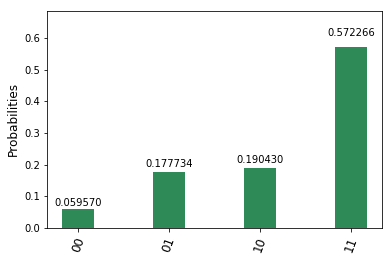

In [4]:
plot_histogram(result.get_counts(params))

## The Algorithm for Log(Log(p)) Qubits

The algorithm is quite simple as follows.
1. Prepare quantum and classical registers for $ log(log(p)) + 1 $ qubits initialized to zero. The $ log(log(p))$ qubits will act as your control bits and the 1 extra will act as your target bit. 
$$ |0\ldots 0\rangle |0\rangle  $$ 
2. Hadamard the control bits to put them in a superposition so that we can perform multiple QFA's at the same time.
3. For each of $s $ states in the superposition, we can perform an individual QFA with the control qubits acting as the random integer $ k $ from the previous algorithm. Thus, we need $ n $ values from $ 0... log(p)$ for $ k $. For each letter $ i $ in the string, we perform a controlled y-rotation on the target qubit, where $ \theta $ is initially zero and $ \Phi $ is the angle of rotation for each unitary. $$ \Phi = \frac{2 \pi k_{s}}{p} $$
4. The target qubit in the final state: 
$$ \cos \theta |0\rangle + \sin \theta |1\rangle $$

$$ \theta = \sum_{s=0}^n \frac{2 \pi k_{s}} p {i} $$
5. Measure the target qubit in the classical register. If $ i $ divides $ p $, $ \cos \theta $ will collapse to one for every qubit and $ |0\rangle $  will demonstrate an accept state with a probability of one. Otherwise, the output will consist of a small proability of accepting the string into the langauge and a higer probability of rejecting the string.